CNN Model for Malaria Diagnosis

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization, Input, Layer, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from google.colab import drive
from tensorflow.keras.regularizers import L2, L1
from sklearn.metrics import confusion_matrix, roc_curve
import sklearn
import seaborn as sns

### **Dataset Loading**

In [ ]:
# Load in the data from Google's Database.
data, data_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files = True, split = ['train'])

In [ ]:
print(data_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear i

In [ ]:
# Splitting the dataset into training, validation and test datasets.

# Function to split the data for any ratio's
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    if(TRAIN_RATIO + VAL_RATIO + TEST_RATIO != 1.0): # Check to avoid bad splits.
      raise Exception("SUM OF RATIO'S NOT EQUAL TO 1\n")

    DATASET_SIZE = len(dataset)
    # Lengths of the splits.
    TRAIN_LENGTH = int(DATASET_SIZE * TRAIN_RATIO)
    VAL_LENGTH = int(DATASET_SIZE * VAL_RATIO)
    TEST_LENGTH = int(DATASET_SIZE * TEST_RATIO)

    # Split the dataset
    train_set = dataset.take(TRAIN_LENGTH)
    val_set = dataset.skip(TRAIN_LENGTH)
    val_set = val_set.take(VAL_LENGTH)
    test_set = dataset.skip(TRAIN_LENGTH + VAL_LENGTH)
    return train_set, val_set, test_set

train_set, val_set, test_set = splits(data[0], 0.8, 0.1, 0.1)

### **Dataset Visualization**

#### Dataset Augmentation

In [ ]:
def visualize(original, augmented):
  plt.subplot(1, 2, 1)
  plt.imshow(original)

  plt.subplot(1, 2, 2)
  plt.imshow(augmented)

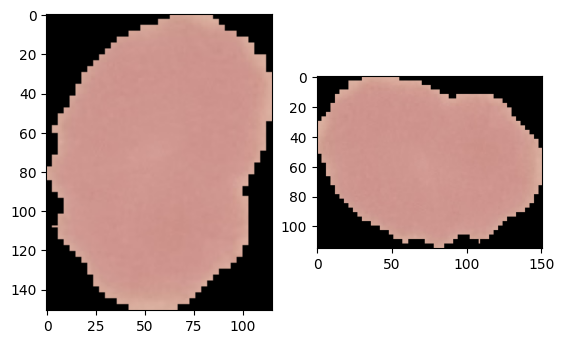

In [ ]:
original_image , label = next(iter(train_set))
augmented_image = tf.image.rot90(original_image)
visualize(original_image, augmented_image)

#### Data Visuals

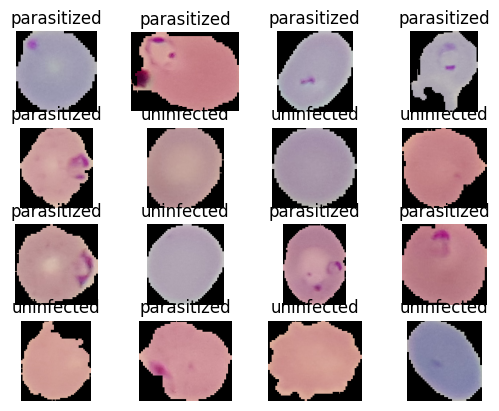

In [ ]:
for i, (image, label) in enumerate(train_set.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(data_info.features['label'].int2str(label))
    plt.axis("off")

### **Data Preprocessing**

#### Resizing Images and Augmenting Images

In [ ]:
IM_SIZE = 224
def resizing_rescaling(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255, label # Using Tensorflow's in-built function to resize images.
  # Normalizing the images using the formula X -> (X - Xmin)/(Xmax - Xmin). For an image, Xmax = 255, Xmin = 0 -> X => X/255 for the scaling.

#### Simple Augmentation

In [ ]:
def augment(image, label):

  image, label = resizing_rescaling(image, label)

  image = tf.image.rot90(image, k = tf.random.uniform(shape = [], minval = 1, maxval = 3, dtype = tf.dtypes.int32))
  # image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  # image = tf.image.stateless_random_saturation(image, 0.3, 0.5)
  # image = tf.image.flip_left_right(image)
  # image = tf.image.stateless_random_flip_left_right(image, seed = (0,0))

  return image, label

#### MixUp Data Augmentation

In [ ]:
train_set_1 = train_set.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resizing_rescaling)
train_set_2 = train_set.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resizing_rescaling)

mixed_set = tf.data.Dataset.zip(train_set_1, train_set_2)

def mixup(train_set_1, train_set_2):
  (image_1, label_1), (image_2, label_2) = train_set_1, train_set_2

  lamda = tfp.distributions.Beta(0.2, 0.2)

  image = lamda * image_1 + (1 - lamda) * image_2
  label = lamda * tf.cast(label_1, dtype = tf.dtypes.float32) + (1 - lamda) * tf.cast(label_2, dtype = tf.dtypes.float32)
  return image, label

#### Cutmix Data Augmentation

In [ ]:
def box(lamda):
  # Generate a center of the bounding box randomly
  rx = tf.cast(tfp.distributions.Uniform(low=0.0,high=IM_SIZE), dtype = tf.dtypes.int32)
  ry = tf.cast(tfp.distributions.Uniform(low = 0.0, high = IM_SIZE), dtype = tf.dtypes.int32)

  # Get the random width and height of the bounding box.
  rw = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype = tf.dtypes.int32)
  rh = tf.cast(IM_SIZE * tf.math.sqrt(1 - lamda), dtype = tf.dtypes.int32)


  # Making sure that the bounding box in entirely inside the image.
  rx = tf.clip_by_value(rx - rw//2, 0, IM_SIZE)
  ry = tf.clip_by_value(ry - rh//2, 0, IM_SIZE)

  x_bottom_right = tf.clip_by_value(rx + rw//2, 0, IM_SIZE)
  y_bottom_right = tf.clip_by_value(ry + rh//2, 0, IM_SIZE)

  rw = x_bottom_right - rx
  if(rw == 0):
    rw = 1
  rh = y_bottom_right - ry
  if(rh == 0):
    rh = 1

  return ry, rx, rh, rw

In [ ]:
train_set_1 = train_set.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resizing_rescaling)
train_set_2 = train_set.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(resizing_rescaling)

# Mix up the dataset which contain shuffled images.
mixed_set = tf.data.Dataset.zip(train_set_1, train_set_2)

# This will mix the two images, of the two datasets as image = lamda * image_1 + (1 - lamda) * image_2
def cutmix(train_set_1, train_set_2):
  (image_1, label_1), (image_2, label_2) = train_set_1, train_set_2

  lamda = tfp.distributions.Beta(0.2, 0.2)

  ry, rx, rw, rh = box(lamda)

  crop_2 = tf.image.crop_to_bounding_box(image_2, ry, rx, rh, rw)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, ry, rx, IM_SIZE, IM_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, ry, rx, rh, rw)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, ry, rx, IM_SIZE, IM_SIZE)

  image = image_1 - image_4 + image_3

  lamda = tf.cast(1 - (rh * rw)/(IM_SIZE * IM_SIZE), dtype = tf.dtypes.float32)

  label = lamda * tf.cast(label_1, dtype = tf.dtypes.float32) + (1 - lamda) * tf.cast(label_2, dtype = tf.dtypes.float32)

  return image, label


#### Preparing Datasets for Training

In [ ]:
BATCH_SIZE = 32

# Training Set
training_dataset = train_set.shuffle(buffer_size = 8, reshuffle_each_iteration = True).map(augment).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation Set

val_set = val_set.map(resizing_rescaling)
validation_dataset = val_set.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # Shuffle the images.

# Test Set

test_set = test_set.map(resizing_rescaling)
test_dataset = test_set.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(1).prefetch(tf.data.AUTOTUNE) # Shuffle the images.

## **Model**


This section contains defining the models using various APIs available to define neural networks

### **Sequential API Definition**

In [ ]:
IM_SIZE = 224
dropout_rate = 0.3
regularization_rate = 0.01

model = tf.keras.Sequential([
    # Input Layer, takes in an RGB image of resoultion (IM_SIZE, IM_SIZE).
    InputLayer((IM_SIZE, IM_SIZE, 3)),

    # Processing Layer 1 (Convolution + Pooling)
    Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu',
            kernel_regularizer = L2(l2=regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),
    Dropout(rate = dropout_rate),

    #Processing Layer 2 (Convolution + Pooling)
    Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu',
           kernel_regularizer = L2(l2=regularization_rate)),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    # Flatten out the resulting image, and connect to a neural network. (Convert from 2D to 1D)
    Flatten(),

    # Layers of Neural Network.
    Dense(100, activation = 'relu', kernel_regularizer = L2(l2=regularization_rate)),
    BatchNormalization(),
    Dropout(rate = dropout_rate),

    Dense(10, activation = 'relu', kernel_regularizer = L2(l2=regularization_rate)),
    BatchNormalization(),
    # Output Layer
    Dense(1, activation = 'sigmoid')
])
model.summary()
# This model contains 4.6 million parameters to be optimised and fine-tuned.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     6

In [ ]:
# Define the model parameters and compile it.
model.compile(optimizer = Adam(learning_rate = 0.1), loss = BinaryCrossentropy(), metrics = 'accuracy')

In [ ]:
# Train the model.
history = model.fit(train_dataset, validation_data = val_dataset, epochs = 10, verbose = 1)

Epoch 1/10
295/689 [===========>..................] - ETA: 18s - loss: 56.0268 - accuracy: 0.5640

KeyboardInterrupt: ignored

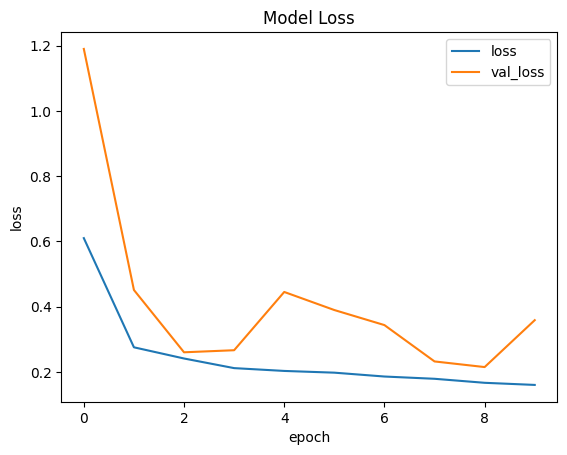

In [ ]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


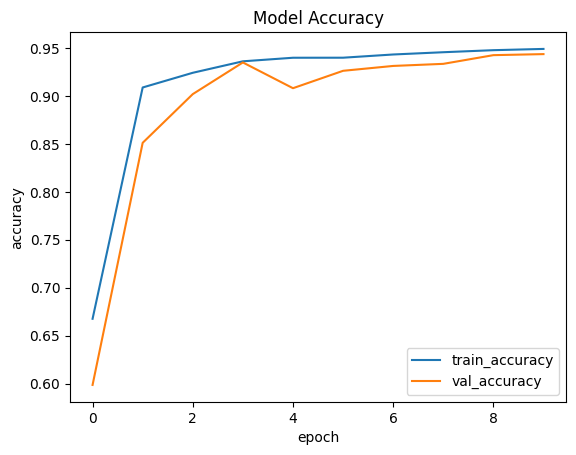

In [ ]:
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()


#### Model Evaluation

In [ ]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 22s 4ms/step - loss: 0.5307 - accuracy: 0.9365


[0.5306605696678162, 0.9365252256393433]

In [ ]:
# A function to predict class of the input, given probability
def parasite_or_not(X):
  if(X<0.5):
    return str('P')
  return str('U')

print(model.predict(test_dataset.take(1))[0][0])
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 13s 13s/step
0.99869245
1/1 [==============================] - 20s 20s/step


'U'

1/1 [==============================] - 0s 17ms/step


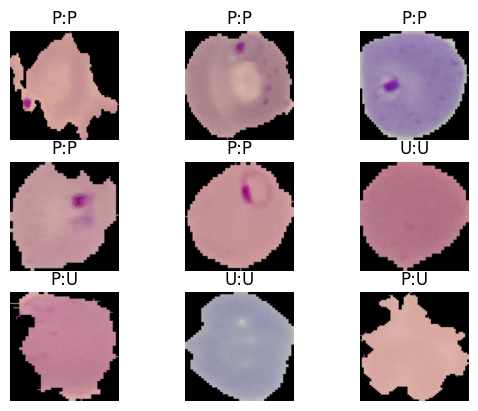

In [ ]:
# To see how well the trained model performs.
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ':' + str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')

### **Functional API Definition**

Functional API is used to create recallable models (just as a function) which is not possible in a sequential API definition, and allows for complex model definitions to be made.

#### Feature Extractor Layer

In [ ]:

class FeatureExtractor(Layer):
  def __init__(self, filters_1 = 6, filters_2 = 16, kernel_size_1 = 3, kernel_size_2 = 3
               ,strides_1 = 1,strides_2 = 1, padding_1 = 'valid', padding_2 = 'valid', activation_1 = 'relu',
               activation_2 = 'relu', pool_size_1 = 2, pool_size_2 = 2, regularization_rate = 1e-5, dropout_rate = 0.3):
    super(FeatureExtractor, self).__init__()

    # Processing Layer 1 (L2 regularized Convolution + Normalization + Pooling)
    self.conv_1 = Conv2D(filters = filters_1, kernel_size = kernel_size_1,
                         strides = strides_1,
                         padding = padding_1, activation = activation_1,
     ) #kernel_regularizer = L2(l2=regularization_rate))
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size = pool_size_1, strides = 2 * strides_1)
    # self.dropout_1 = Dropout(rate = dropout_rate)

    # Processing Layer 2 (L2 regularized Convolution + Normalization + Pooling)
    self.conv_2 = Conv2D(filters = filters_2, kernel_size = kernel_size_2,
                         strides = strides_2,
                         padding = padding_2, activation = activation_2,
    ) #kernel_regularizer = L2(l2=regularization_rate))
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size = pool_size_2, strides = 2 * strides_2)

  def call(self, x):

    # Processing Layer 1
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)
    # x = self.dropout_1(x)

    # Processing Layer 2
    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

#### Model Definition as a Class and Training

In [ ]:
dropout_rate = 0.3
class FunctionalModel(Model):
  def __init__(self):
    super(FunctionalModel, self).__init__()

    self.feature_extractor = FeatureExtractor()

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation = 'relu') # Input Layer of Neural Network
    self.batch_1 = BatchNormalization()
    self.dense_2 = Dense(10, activation = 'relu') # Hidden Layer 1 of Neural Network
    self.batch_2 = BatchNormalization()
    # self.dropout = Dropout(rate = dropout_rate)
    self.dense_3 = Dense(1, activation = 'sigmoid')

  def call(self, x):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    # x = self.dropout(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)

    return x

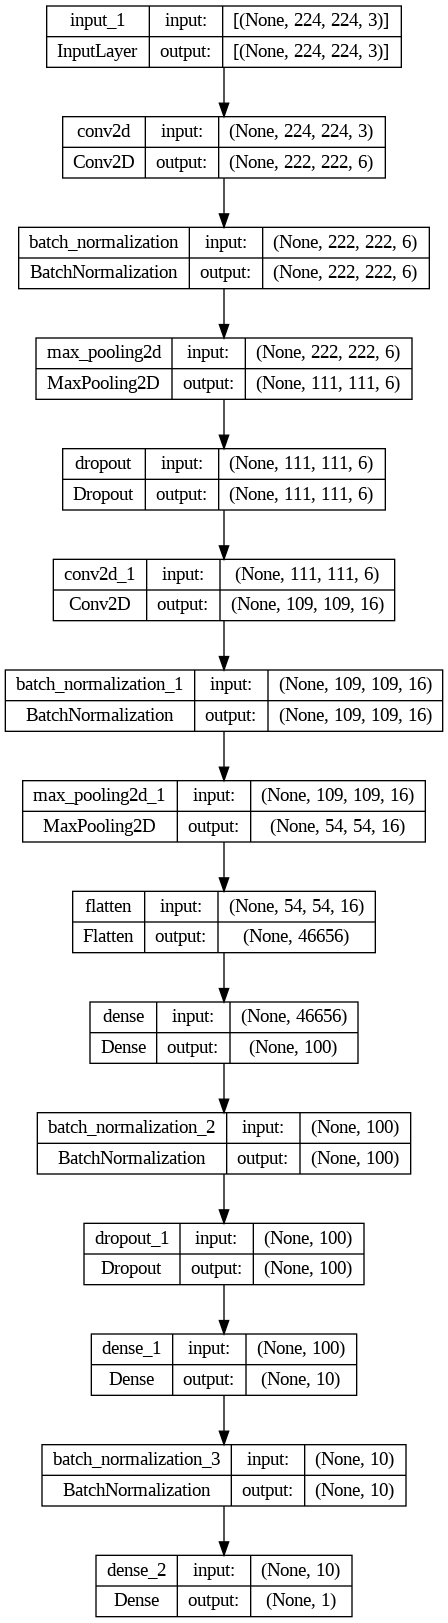

In [ ]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes=True)

In [ ]:
IM_SIZE = 224
model = FunctionalModel()
model(tf.zeros([1,IM_SIZE,IM_SIZE,3]))
model.summary()

Model: "functional_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor (FeatureE  multiple                 1136      
 xtractor)                                                       
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  4665700   
                                                                 
 batch_normalization_2 (Batc  multiple                 400       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             multiple                  1010      
                                                                 
 batch_normalization_3 (Batc  multiple            

In [ ]:
metrics = [TruePositives(name = 'tp'), TrueNegatives(name = 'tn'), FalsePositives(name = 'fp'), FalseNegatives(name = 'fn'), BinaryAccuracy(name = 'accuracy'),
           Precision(name = 'precision'), Recall(name = 'recall'), AUC(name = 'auc')]

##### Callbacks

In [ ]:
class LossCallBack(Callback):
  def on_epoch_end(self, epoch, logs):
    print(f"For Epoch Number {epoch+1} Loss : {logs['logs']}")
  def on_batch_end(self, batch, logs):
    print(f"For Batch Number {batch+1} Loss : {logs['logs']}")


In [ ]:
csv_logs = CSVLogger('logs.csv', separator=',', append=False)

In [ ]:
es_callback = EarlyStopping(
    monitor = 'val_loss', min_delta = 0.01, patience = 5, verbose = 1,
    mode = 'auto', baseline = None, restore_best_weights = True
)

In [ ]:
def scheduler(epoch, lr):
  if epoch <= 3:
    return lr
  return lr * tf.math.exp(-0.1)

scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
checkpoint_callback = ModelCheckpoint('checkpoint/', monitor = 'val_loss', verbose = 0, save_best_only = True, save_weights_only = False, mode = 'auto', save_freq = 3)

In [ ]:
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.001, verbose = 1)

In [ ]:
callbacks = [es_callback]

##### Model Training

In [ ]:
model.compile(optimizer = Adam(learning_rate = 0.1), loss = BinaryCrossentropy(), metrics = metrics)

In [ ]:
history = model.fit(training_dataset, validation_data = validation_dataset, epochs = 20, verbose = 1, callbacks = callbacks)

Epoch 1/20
1378/1378 [==============================] - 100s 67ms/step - loss: 0.4128 - tp: 18164.0000 - tn: 17752.0000 - fp: 4293.0000 - fn: 3883.0000 - accuracy: 0.8146 - precision: 0.8088 - recall: 0.8239 - auc: 0.8947 - val_loss: 0.6771 - val_tp: 1374.0000 - val_tn: 854.0000 - val_fp: 513.0000 - val_fn: 14.0000 - val_accuracy: 0.8087 - val_precision: 0.7281 - val_recall: 0.9899 - val_auc: 0.9371
Epoch 2/20
1378/1378 [==============================] - 91s 66ms/step - loss: 0.2440 - tp: 20737.0000 - tn: 20068.0000 - fp: 1975.0000 - fn: 1312.0000 - accuracy: 0.9255 - precision: 0.9130 - recall: 0.9405 - auc: 0.9542 - val_loss: 0.6790 - val_tp: 1382.0000 - val_tn: 786.0000 - val_fp: 577.0000 - val_fn: 10.0000 - val_accuracy: 0.7869 - val_precision: 0.7055 - val_recall: 0.9928 - val_auc: 0.9160
Epoch 3/20
1378/1378 [==============================] - 91s 66ms/step - loss: 0.2259 - tp: 20952.0000 - tn: 20081.0000 - fp: 1962.0000 - fn: 1097.0000 - accuracy: 0.9306 - precision: 0.9144 - rec

#### Evaluating the model, and optimizing the model to reduce false positives.

In [ ]:
labels = []
inp = []
for x,y in test_dataset.as_numpy_iterator():
  labels.append(y)
  inp.append(x)

labels = np.array([i[0] for i in labels])
inp = np.array(inp)[:,0,...]
print(labels)

[0 1 0 ... 0 1 0]


In [ ]:
preds = model.predict(inp)[:,0]

87/87 [==============================] - 2s 18ms/step


In [ ]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 26s 6ms/step - loss: 0.1665 - tp: 1316.0000 - tn: 1298.0000 - fp: 95.0000 - fn: 48.0000 - accuracy: 0.9481 - precision: 0.9327 - recall: 0.9648 - auc: 0.9788


[0.16653472185134888,
 1316.0,
 1298.0,
 95.0,
 48.0,
 0.9481320381164551,
 0.932671844959259,
 0.9648093581199646,
 0.9788116216659546]

[[1318   73]
 [  75 1291]]


Text(0.5, 1.0, 'Confusion Matrix - 0.7722325')

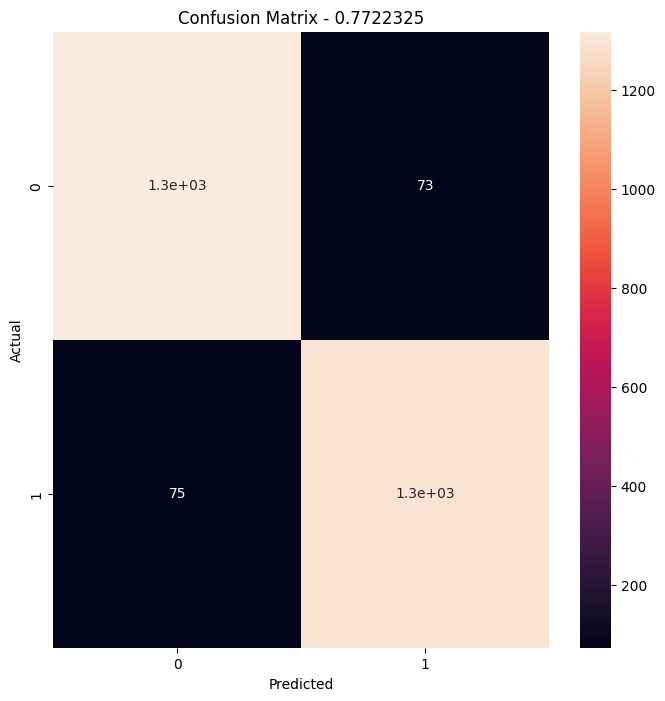

In [ ]:
threshold = 0.7722325 # To reduce false positives.

cm = confusion_matrix(labels, preds > threshold)
print(cm)

plt.figure(figsize = (8,8))

sns.heatmap(cm, annot = True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix - {threshold}')

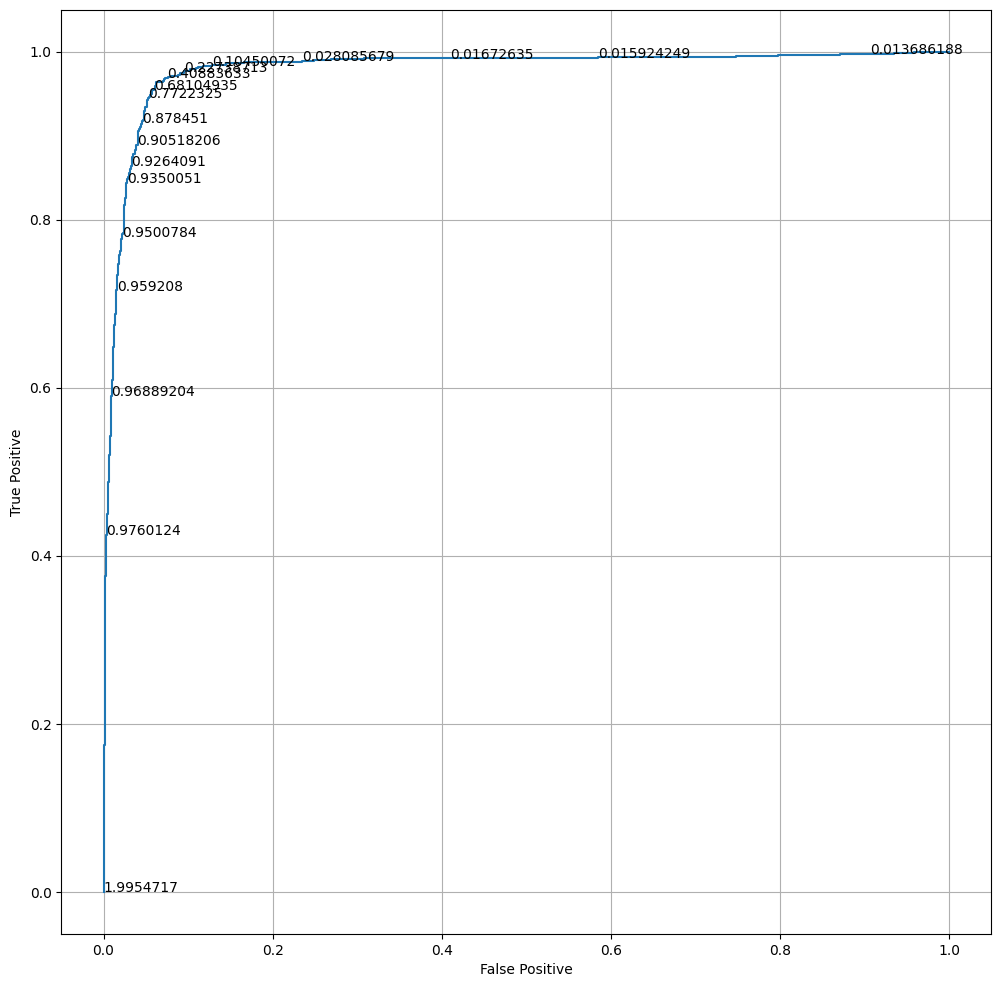

In [ ]:
# ROC Curve of the trained model.
fp, tp, thresholds = roc_curve(labels, preds)
plt.figure(figsize = (12,12))
plt.plot(fp, tp)
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.grid()

s = 15
for i in range(0, len(thresholds), s):
  plt.text(fp[i], tp[i], thresholds[i])
plt.show()

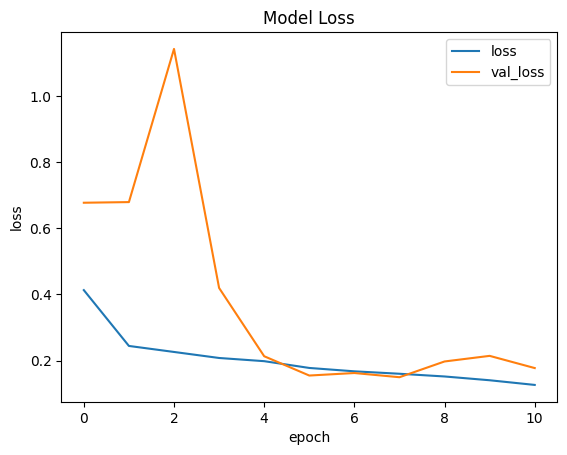

In [ ]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

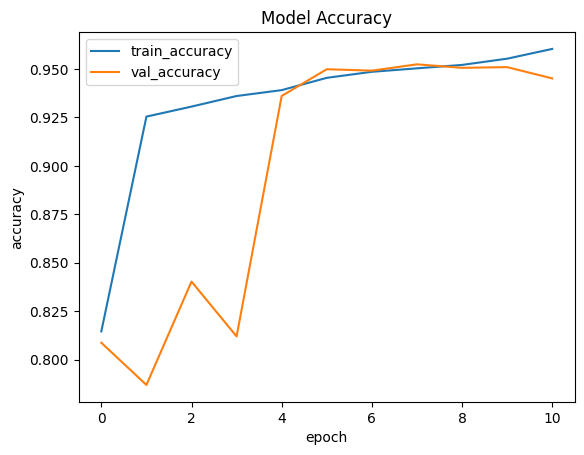

In [ ]:
plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [ ]:
# A function to predict class of the input, given probability
def parasite_or_not(X):
  if(X<threshold):
    return str('P')
  return str('U')

print(model.predict(test_dataset.take(1))[0][0])
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 12s 12s/step
0.8907578
1/1 [==============================] - 11s 11s/step


'P'

1/1 [==============================] - 0s 19ms/step


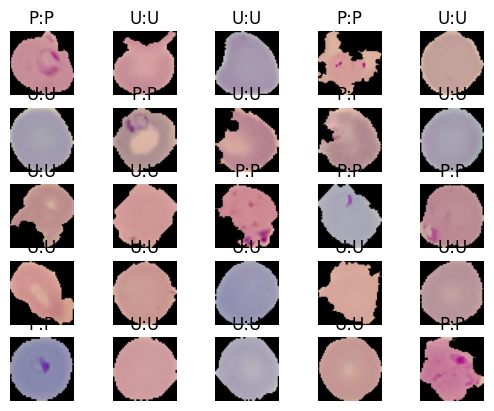

In [ ]:
# To see how well the trained model performs.
for i, (image, label) in enumerate(test_dataset.take(25)):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ':' + str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')

#### Other ways to define the same model

In [ ]:
# # Definition of the feautute extractor model. Processes the input images and returns a processed feauture set.
# IM_SIZE = 224
# feature_extractor_model = tf.keras.Sequential([
#     # Input Layer, takes in an RGB image of resoultion (IM_SIZE, IM_SIZE).
#     InputLayer((IM_SIZE, IM_SIZE, 3)),

#     # Processing Layer 1 (Convolution + Pooling)
#     Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
#     BatchNormalization(),
#     MaxPool2D(pool_size = 2, strides = 2),

#     #Processing Layer 2 (Convolution + Pooling)
#     Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
#     BatchNormalization(),
#     MaxPool2D(pool_size = 2, strides = 2)
# ])
# feature_extractor_model.summary()

In [ ]:
# # Definition of the model. Similar structure to the Sequential API's one, just created using a Functional API (As a function) instead.

# # Input Layer, takes in an input image.
# func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input_Image")

# # The feature extractor model, processes the input image and returns a feature set => Input of the neural network.
# x = feature_extractor_model(func_input)

# # Flatten out the resulting image, and connect to a neural network. (Convert from 2D to 1D)
# x = Flatten()(x)

# # Layers of Neural Network.
# x = Dense(100, activation = 'relu')(x)
# x = BatchNormalization()(x)
# x = Dense(10, activation = 'relu')(x)
# x = BatchNormalization()(x)

# # Output Layer
# func_output = Dense(1, activation = 'sigmoid')(x)

# model = Model(func_input, func_output, name = "Lenet_Model")
# model.summary()
# # This model contains 4.6 million parameters all of which can be varied independently.